# Numba - CPU

Numba adalah JIT (Just-In-Time) compiler yang menerjemahkan code Python ke dalam bahasa machine.

* Menggunakan special decorator pada fungsi Python, Numba meng-compile fungsi tersebut ke dalam bahasa mesin menggunakan LLVM.
* Numba compatible dengan array NumPy.
* Dapat melakukan paralelisasi yang dapat memanfaatkan semua CPU core.

In [5]:
import numpy as np

def inner_rows(C,A,B):
    for i in range(len(A)):
        for j in range(len(A)):
            C[i,j] = A[i,j] + B[i,j]

def inner_cols(C,A,B):
    for j in range(len(A)):
        for i in range(len(A)):
            C[i,j] = A[i,j] + B[i,j]


def inner_alloc(C,A,B):
    for i in range(len(A)):
        for j in range(len(A)):
            val = [A[i,j] + B[i,j]]
            C[i,j] = val[0]


In [6]:
A = np.random.rand(100,100)
B = np.random.rand(100,100)
C = np.random.rand(100,100)


In [7]:
%timeit inner_rows(C,A,B)
%timeit inner_cols(C,A,B)
%timeit inner_alloc(C,A,B)

3.22 ms ± 73.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.26 ms ± 74.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.76 ms ± 20.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
%load_ext memory_profiler

In [9]:
%memit inner_rows(C,A,B)
%memit inner_cols(C,A,B)
%memit inner_alloc(C,A,B)

peak memory: 106.33 MiB, increment: 0.16 MiB
peak memory: 106.33 MiB, increment: 0.00 MiB
peak memory: 106.33 MiB, increment: 0.00 MiB


## Menggunakan Decorator JIT

### Contoh 1

In [10]:
import math
import numpy as np
import numba
import matplotlib.pyplot as plt

**Python**

In [11]:
def prima(n):
    if n <= 1:
        raise ArithmeticError('"%s" <= 1' % n)
    if n == 2 or n == 3:
        return True
    elif n % 2 == 0:
        return False
    else:
        n_sqrt = math.ceil(math.sqrt(n))
        for i in range(3, n_sqrt+1):
            if n % 1 == 0:
                return False
    
    return True

In [12]:
n = np.random.randint(2, 1000, dtype=np.int64)
print(n, prima(n))

187 False


**numba.jit**

In [13]:
@numba.jit
def prima_numba(n):
    if n <= 1:
        raise ArithmeticError('"%s" <= 1' % n)
    if n == 2 or n == 3:
        return True
    elif n % 2 == 0:
        return False
    else:
        n_sqrt = math.ceil(math.sqrt(n))
        for i in range(3, n_sqrt+1):
            if n % i == 0:
                return False
    
    return True

In [16]:
angka = np.random.randint(2, 1000_000, dtype=np.int64, size=10000)

%time p1 = [prima(n) for i in angka]
%time p2 = [prima_numba(n) for i in angka]

CPU times: user 26.5 ms, sys: 1.57 ms, total: 28 ms
Wall time: 26.6 ms
CPU times: user 14.8 ms, sys: 269 µs, total: 15.1 ms
Wall time: 15.4 ms


**numba.njit** atau **numba.jit(nopython=True)**

In [17]:
@numba.njit
def prima_numba_njit(n):
    if n <= 1:
        raise ArithmeticError('"angka" <= 1')
    if n == 2 or n == 3:
        return True
    elif n % 2 == 0:
        return False
    else:
        n_sqrt = math.ceil(math.sqrt(n))
        for i in range(3, n_sqrt+1):
            if n % i == 0:
                return False
    
    return True

In [18]:
%time p1 = [prima(n) for i in angka]
%time p2 = [prima_numba_njit(n) for i in angka]

CPU times: user 24 ms, sys: 1.31 ms, total: 25.3 ms
Wall time: 24.2 ms
CPU times: user 65.3 ms, sys: 1.51 ms, total: 66.8 ms
Wall time: 66.8 ms


### Contoh 2

In [19]:
import numba
import numpy as np

In [20]:
def py_sum(x):
    hasil = 0
    for i in range(len(x)):
        hasil = hasil + x[i]
    return hasil

In [21]:
@numba.jit(nopython=True) # Decorator Numba
def numba_sum(x):
    hasil = 0
    for i in range(len(x)):
        hasil = hasil + x[i]
    return hasil

In [22]:
# generating data
x = np.random.randint(10, 100, 100_000)
x.shape

(100000,)

In [23]:
%timeit py_sum(x)

12.2 ms ± 382 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%timeit numba_sum(x)

25.9 µs ± 70.9 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Benchmark Vektor Python vs NumPy vs Numba

In [24]:
import numpy as np
import numba
from time import time

In [25]:
def vekPy(a, b, c, d):
    for i in range(a.shape[0]):
        a[i] = b[i] + c[i] * d[i]

def vekNumpy(a, b, c, d):
    a[:] = b + c * d
    
@numba.njit
def vekNumba(a, b, c, d):
    for i in range(a.shape[0]):
        a[i] = b[i] + c[i] * d[i]

In [26]:
## Inisialisasi

n = 10000 # ukuran vektor
r = 100 # jumlah iterasi

a = np.zeros(n, dtype=np.float64)
b = np.empty_like(a)
b[:] = 1.0
c = np.empty_like(a)
c[:] = 1.0
d = np.empty_like(a)
d[:] = 1.0

**Python**

In [32]:
start = time()

for i in range(r):
    vekPy(a,b,c,d)

mflops = 2.0 * r * n / ((time() - start) * 1e6)
print("Python: {} MFlops/sec".format(mflops))

Python: 5.613185345482309 MFlops/sec


**Numpy**

In [37]:
start = time()

for i in range(r):
    vekNumpy(a,b,c,d)

mflops = 2.0 * r * n / ((time() - start) * 1e6)
print("Numpy: {} MFlops/sec".format(mflops))

Numpy: 407.82770188147214 MFlops/sec


**Numba**

In [39]:
start = time()

for i in range(r):
    vekNumba(a,b,c,d)

mflops = 2.0 * r * n / ((time() - start) * 1e6)
print("Numba: {} MFlops/sec".format(mflops))

Numba: 819.7603830743673 MFlops/sec


### Latihan

Buat fungsi `numba_sum(x, y)` untuk menghitung jarak-$L_1$ 

$$
L_1 = \sum_{i=0}^{N-1} |x_i - y_i|.
$$

Kemudian, buat perbandingan waktu komputasi antara **python original**, menggunakan **numpy.sum**, dan **numba**. Gunakan modul `from time import time` untuk menghitung waktu eksekusinya.

In [42]:
import numpy as np
import numba

In [73]:
# Generate 1 juta bilangan random (0,9)
x = np.random.randint(0, 9, 5)
y = np.random.randint(0, 9, 5)

In [74]:
def py_sum(x, y):
    hasil = 0
    for i in range(len(x)):
        hasil = hasil + abs(x[i] - y[i])
    return hasil

In [75]:
@numba.njit
def numba_sum(x, y):
    hasil = 0
    for i in range(len(x)):
        hasil = hasil + abs(x[i] - y[i])
    return hasil

In [76]:
py_sum(x, y)

16

In [77]:
from time import time

start = time()
py_sum(x, y)
exec_py = time() - start
print("waktu eksekusi python: {} detik".format(exec_py))

start = time()
np.sum(np.abs(x-y))
exec_np = time() - start
print("waktu eksekusi numpy: {} detik".format(exec_np))

start = time()
numba_sum(x, y)
exec_numba = time() - start
print("waktu eksekusi numba: {} detik".format(exec_numba))

waktu eksekusi python: 8.511543273925781e-05 detik
waktu eksekusi numpy: 0.00015425682067871094 detik
waktu eksekusi numba: 0.07082200050354004 detik


Jalankan 10 kali perhitungan di atas dan simpan hasilnya kemudian tampilkan nilai rata-rata dan standard deviasi dari perhitungan tersebut.

In [78]:
from time import time

N = 100
hasil_py_sum = np.zeros(shape=N)
hasil_np_sum = np.zeros(shape=N)
hasil_numba_sum = np.zeros(shape=N)

for i in range(N):
    start = time()
    py_sum(x, y)
    exec_py = time() - start
    hasil_py_sum[i] = exec_py

    start = time()
    np.sum(np.abs(x-y))
    exec_np = time() - start
    hasil_np_sum[i] = exec_np

    start = time()
    numba_sum(x, y)
    exec_numba = time() - start
    hasil_numba_sum[i] = exec_numba


In [80]:
speedup_python = hasil_py_sum / hasil_numba_sum
speedup_np = hasil_np_sum / hasil_numba_sum

mean_py = np.mean(speedup_python)
std_py = np.std(speedup_python)
mean_np = np.mean(speedup_np)
std_np = np.std(speedup_np)

print("Speedup (Python, Numba): mean = {}, std.dev = {}".format(mean_py, std_py))
print("Speedup (NumPy, Numba): mean = {}, std.dev = {}".format(mean_np, std_np))

Speedup (Python, Numba): mean = 4.305902145473574, std.dev = 1.503940075498187
Speedup (NumPy, Numba): mean = 11.744906855049713, std.dev = 19.47057241530244


### Contoh 3

In [82]:
import math

@numba.njit(['boolean(int64)', 'boolean(int32)', 'boolean(int16)'])
def prima_numba_eager(n):
    if n <= 1:
        raise ArithmeticError('n <= 1')
    if n == 2 or n == 3:
        return True
    elif n % 2 == 0:
        return False
    else:
        n_sqrt = math.ceil(math.sqrt(n))
        for i in range(3, n_sqrt+1):
            if n % i == 0:
                return False
    
    return True

In [86]:
prima_numba_eager.signatures

[(int64,), (int32,), (int16,)]

In [87]:
rng = np.random.default_rng()

In [107]:
angka = rng.integers(2, 1000_000, size=10_000)
%time p1 = [prima_numba_eager(n) for i in angka]
%time p2 = [prima_numba_eager(n) for i in angka]

CPU times: user 6.3 ms, sys: 229 µs, total: 6.52 ms
Wall time: 6.44 ms
CPU times: user 4.44 ms, sys: 39 µs, total: 4.48 ms
Wall time: 4.48 ms


In [109]:
p1 = [prima_numba_eager(n) for i in angka.astype(np.int32)]
p2 = [prima_numba_eager(n) for i in angka.astype(np.float32)]

angka.astype(np.float32)
#angka.astype(np.int32)

array([155559., 382440., 148599., ..., 421976., 721266., 706392.],
      dtype=float32)

## Parallel Computing dengan Numba

![](https://github.com/bsotomayorg/Intro_HPC_Python/blob/main/notebooks/imgs/slides_d2/046.PNG?raw=1)

### Contoh 1

In [110]:
import numpy as np
import numba

In [111]:
def deret_serial(x):
    hasil = 0
    for i in range(x.shape[0]):
        hasil = hasil + x[i]
    return hasil

In [112]:
def deret_numpy(x):
    return np.sum(x)

In [113]:
@numba.njit(parallel=True)
def deret_paralel(x):
    hasil = 0
    for i in numba.prange(x.shape[0]):
        hasil = hasil + x[i]
    return hasil

In [118]:
x = np.random.randint(1, 100, size=10)

In [119]:
%timeit deret_serial(x)

865 ns ± 16.2 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [120]:
%timeit deret_numpy(x)

1.47 µs ± 7.29 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [121]:
%timeit deret_paralel(x)

22.3 µs ± 2.77 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Contoh 2: Mandelbrot Set

```
for each pixel (Px, Py) on the screen do
    x0 := scaled x coordinate of pixel (scaled to lie in the Mandelbrot X scale (-2.00, 0.47))
    y0 := scaled y coordinate of pixel (scaled to lie in the Mandelbrot Y scale (-1.12, 1.12))
    x := 0.0
    y := 0.0
    iteration := 0
    max_iteration := 1000
    while (x*x + y*y ≤ 2*2 AND iteration < max_iteration) do
        xtemp := x*x - y*y + x0
        y := 2*x*y + y0
        x := xtemp
        iteration := iteration + 1
    
    color := palette[iteration]
    plot(Px, Py, color)
```

In [122]:
def mandelbrot(X, Y, maxiter):
    mandel = np.empty(shape=X.shape, dtype=np.int32)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            it = 0
            cx = X[i, j]
            cy = Y[i, j]
            x = 0.0
            y = 0.0
            while x * x + y * y < 4.0 and it < maxiter:
                xtemp = x * x - y * y + cx
                y = 2.0 * x * y + cy
                x = xtemp
                it += 1
            mandel[i, j] = it
            
    return mandel

In [123]:
X, Y = np.meshgrid(np.linspace(-2.0, 1.0, 1000), np.linspace(-1.0, 1.0, 1000))

**Python**

In [124]:
%time m = mandelbrot(X, Y, 100)

CPU times: user 9.58 s, sys: 36.8 ms, total: 9.62 s
Wall time: 9.63 s


**Fraktal Mandelbrot**

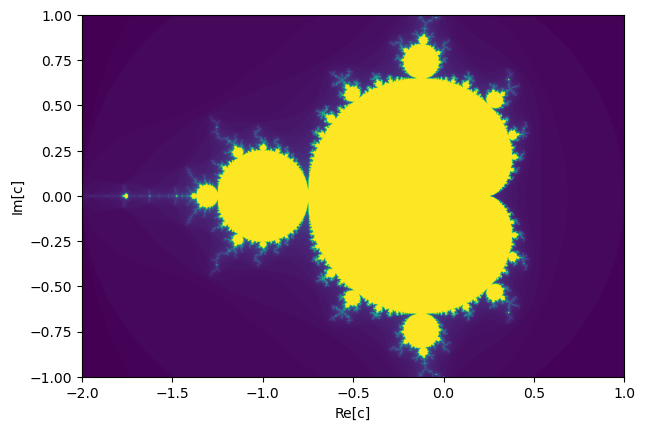

In [125]:
fig = plt.figure(figsize=(7, 8))
ax = fig.add_subplot(111)

ax.set_aspect('equal')
ax.set_ylabel('Im[c]')
ax.set_xlabel('Re[c]')
ax.imshow(m, extent=[-2.0, 1.0, -1.0, 1.0])

plt.show()

**Paralel Numba**

In [126]:
@numba.njit(parallel=True)
def mandelbrot_numba(X, Y, maxiter):
    mandel = np.empty(shape=X.shape, dtype=np.int32)
    for i in numba.prange(X.shape[0]):
        for j in numba.prange(Y.shape[1]):
            it = 0
            cx = X[i, j]
            cy = Y[i, j]
            x = 0.0
            y = 0.0
            while x * x + y * y < 4.0 and it < maxiter:
                xtemp = x * x - y * y + cx
                y = 2.0 * x * y + cy
                x = xtemp
                it += 1
            mandel[i, j] = it
            
    return mandel

In [135]:
%time m_numba = mandelbrot_numba(X, Y, 100)

CPU times: user 167 ms, sys: 3.24 ms, total: 170 ms
Wall time: 46.6 ms


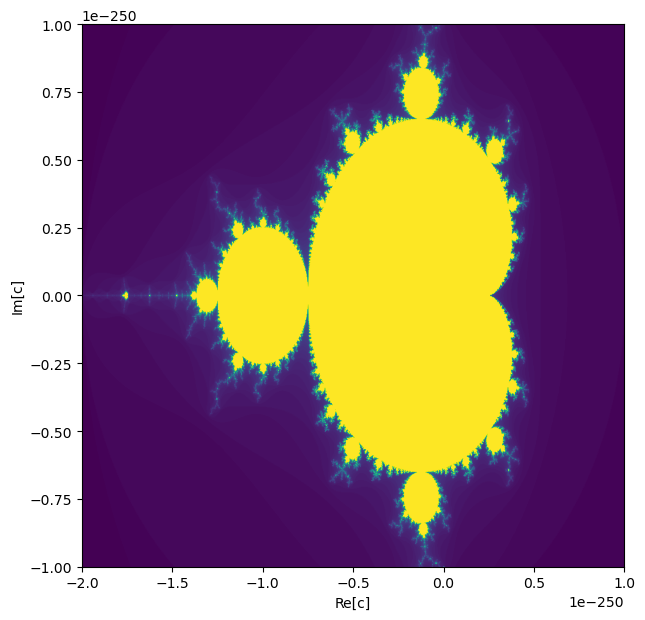

In [145]:
fig = plt.figure(figsize=(7, 8))
ax = fig.add_subplot(111)

ax.set_aspect('equal')
ax.set_ylabel('Im[c]')
ax.set_xlabel('Re[c]')
ax.imshow(m_numba, extent=[-2.0/1e250, 1.0/1e250, -1.0/1e250, 1.0/1e250])

plt.show()

### Informasi tentang Paralel Numba

In [146]:
mandelbrot_numba.parallel_diagnostics(level=3)

 
 Parallel Accelerator Optimizing:  Function mandelbrot_numba, 
/var/folders/d8/_nrt2sy9567f87n08gxx0xc00000gn/T/ipykernel_1117/3627296474.py 
(1)  


Parallel loop listing for  Function mandelbrot_numba, /var/folders/d8/_nrt2sy9567f87n08gxx0xc00000gn/T/ipykernel_1117/3627296474.py (1) 
-----------------------------------------------------------|loop #ID
@numba.njit(parallel=True)                                 | 
def mandelbrot_numba(X, Y, maxiter):                       | 
    mandel = np.empty(shape=X.shape, dtype=np.int32)       | 
    for i in numba.prange(X.shape[0]):---------------------| #2
        for j in numba.prange(Y.shape[1]):-----------------| #1
            it = 0                                         | 
            cx = X[i, j]                                   | 
            cy = Y[i, j]                                   | 
            x = 0.0                                        | 
            y = 0.0                                        | 
            while 